In [2]:
# Need to install escnn first
# !pip install escnn
# !pip install omegaconf

In [1]:
# import os
# # Specify the GPU you want to use, for example, GPU 0
# os.environ["CUDA_VISIBLE_DEVICES"] = "4"
from typing import Tuple
import escnn
import torch
import torchvision
from rot_mnist import RotatedMNIST
import matplotlib.pyplot as plt
import numpy as np
import copy
import kornia as K
from equiv_networks import ESCNNEquivariantNetwork
from canonicalization_discrete_group import DiscreteGroupImageCanonicalization
from can_utils import train_classifer, eval_acc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Create a CNN prediction network and train it on the MNIST dataset

In [3]:
class CNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, hidden_dim):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, hidden_dim, kernel_size),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_dim, hidden_dim, kernel_size),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_dim, out_channels, kernel_size),
        )

    def forward(self, x):
        out = self.model(x)
        # Apply average pooling over spatial dimensions.
        return out.mean((2,3))

prediction_network = CNN(in_channels = 1, out_channels = 10, kernel_size = 5, hidden_dim = 64).to(device)

# Define transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
mnist_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train_dataset, batch_size=512, shuffle=True)
mnist_valid_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_valid_loader = torch.utils.data.DataLoader(dataset=mnist_valid_dataset, batch_size=512, shuffle=False)

optimizer = torch.optim.Adam(prediction_network.parameters(), 0.001) 
train_classifer(prediction_network, mnist_train_loader, mnist_valid_loader, num_epoch = 1, optimizer = optimizer)
# torch.save(prediction_network, "prediction_network.pth")
# prediction_network = torch.load("prediction_network.pth")

number of paramters: 120138
Epoch 1 | Train Accuracy: 0.70757 | Valid Accuracy: 0.90817


## 2. Achieve Equivariance with Canonicalization 

### 2.1 Canonicalization Network: $\phi(x) = c(x)\;f(c^{-1}(x)\;x)$ where $f$ is the prediction network and $c$ is the equivariant network. 

In [4]:
# design canonicalization hyperparams class
class CanonicalizationHyperparams:
    def __init__(self):
        self.network_type = "escnn" # group equivariant canonicalization
        self.resize_shape = 28 # resize shape for the canonicalization network
        self.network_hyperparams = {
            "kernel_size": 5, # Kernel size for the canonization network
            "hidden_dim": 4,
            "out_channels": 4, # Number of output channels for the canonization network
            "num_layers": 5, # Number of layers in the canonization network
            "group_type": "roto-reflection",#"roto-reflection", #rotation", # Type of group for the canonization network
            "group_order": 4, # Number of rotations for the canonization network 
            # "num_rotations": 4
        }
        self.beta = 1.0 
        self.input_crop_ratio = 1.0
        self.gradient_trick = "gumbel_softmax" #"straight_through"
        
canonicalization_hyperparams = CanonicalizationHyperparams()
image_shape = (1, 28, 28)

# Equivariant Network c(x)
canonicalization_network = ESCNNEquivariantNetwork(inp_channels = image_shape[0], **canonicalization_hyperparams.network_hyperparams).to(device)
canonicalizer = DiscreteGroupImageCanonicalization(canonicalization_network, canonicalization_hyperparams, image_shape).to(device)

In [7]:
use_canonicalization = True
f"medsam_text_prompt_loss_time_can{use_canonicalization}.png"

'medsam_text_prompt_loss_time_canTrue.png'

In [12]:
0.8**30

0.0012379400392853823

### 2.2 Train the canonicalization network on the ***rotation*** MNIST datasets

In [5]:
# Load the Rotation MNIST dataset
rot_mnist_train_dataset = RotatedMNIST(root="./data", partition="train", augment="None")
rot_mnist_train_loader = torch.utils.data.DataLoader(rot_mnist_train_dataset, batch_size=512, shuffle=True, num_workers=4)
rot_mnist_valid_dataset = RotatedMNIST(root="./data", partition="valid", augment="None")
rot_mnist_valid_loader = torch.utils.data.DataLoader(rot_mnist_valid_dataset, batch_size=512, shuffle=False, num_workers=4)

# the prediction network perform poorly on the rotated mnist test set.
print("Accuracies of the Prediction Network on the Original and Rotated MNIST Test Sets")
eval_acc(prediction_network, mnist_valid_loader), eval_acc(prediction_network, rot_mnist_valid_loader)

Accuracies of the Prediction Network on the Original and Rotated MNIST Test Sets


(0.90817, 0.23674)

In [6]:
# train canonicalization_network and prediction_network together 0.0001 0.01
# the goal is to make the canonicalization network to produce canonical forms that align with the prediction network.

canonicalization_network = ESCNNEquivariantNetwork(inp_channels = image_shape[0], **canonicalization_hyperparams.network_hyperparams).to(device)
canonicalizer = DiscreteGroupImageCanonicalization(canonicalization_network, canonicalization_hyperparams, image_shape).to(device)
# combine and train together 
can_optimizer = torch.optim.AdamW([
        {'params': prediction_network.parameters(), 'lr': 1e-3},
        {'params': canonicalizer.parameters(), 'lr': 1e-3},
    ])

best_valid_acc = 0
loss_fun = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(can_optimizer, step_size=1, gamma=0.95)
for epoch in range(100):
    train_loss, train_acc, count = [], 0, 0
    for x, y in rot_mnist_train_loader:
        can_optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        canonicalized_x = canonicalizer(x)
        pred = prediction_network(canonicalized_x)
        loss = loss_fun(pred, y) 
        loss += canonicalizer.get_prior_regularization_loss()
        train_loss.append(loss.item())
        train_acc += (y == pred.argmax(dim=-1)).sum().cpu().data.numpy()
        count += y.shape[0]
        loss.backward()
        can_optimizer.step()
    
    for x, y in mnist_train_loader:
        can_optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        canonicalized_x = canonicalizer(x)
        pred = prediction_network(canonicalized_x)
        loss = loss_fun(pred, y) 
        loss += canonicalizer.get_prior_regularization_loss()
        train_loss.append(loss.item())
        train_acc += (y == pred.argmax(dim=-1)).sum().cpu().data.numpy()
        count += y.shape[0]
        loss.backward()
        can_optimizer.step()

    train_acc = train_acc/count
    scheduler.step()
    if epoch % 10 == 0:
        print("Epoch {} | Train Accuracy: {:0.3f} | Train Loss: {:0.3f} ".format(epoch+1, train_acc, np.mean(train_loss)))
        
print("Accuracy of Prediction Network alone on Rotated Test Set: {}".format(eval_acc(prediction_network, rot_mnist_valid_loader)))
print("Accuracy of Canonicalizer + Prediction Network on Rotated Test Set: {}".format(eval_acc(torch.nn.Sequential(canonicalizer, prediction_network), rot_mnist_valid_loader)))      

Epoch 1 | Train Accuracy: 0.473 | Train Loss: 3.363 
Epoch 11 | Train Accuracy: 0.849 | Train Loss: 1.707 


KeyboardInterrupt: 

## Visualization

In [10]:
test_x, test_y = next(iter(rot_mnist_train_loader))

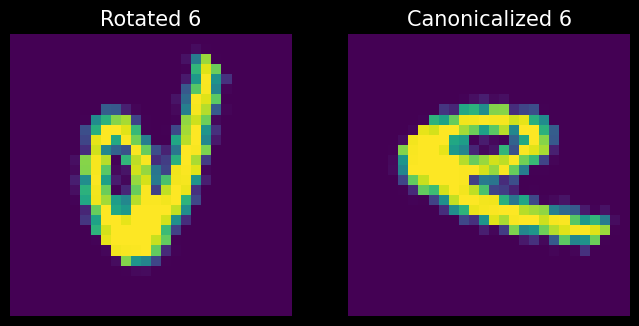

In [13]:
idx = 19
plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_x[idx, 0])
plt.title("Rotated " + str(test_y[idx].numpy()), size = 15)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(canonicalizer(test_x.to(device)).cpu().detach()[idx, 0])
plt.axis("off")
plt.title("Canonicalized " + str(test_y[idx].numpy()), size = 15)
plt.show()

# Test from preloaded Model

In [15]:
# Save model
example_path = "/home/local/ASURITE/longchao/Desktop/project/GE_health/SegmentAsYouWish/canonicalization/example/"
def save_model():
    torch.save(prediction_network.state_dict(), example_path+'prediction_network.pth')
    torch.save(canonicalizer.state_dict(), example_path+'canonicalizer.pth')

In [16]:
# Load test code: 
def load_model():
    prediction_network.load_state_dict(torch.load(example_path+'prediction_network.pth'))
    canonicalizer.load_state_dict(torch.load(example_path+'canonicalizer.pth'))

    # Ensure the models are in eval mode if evaluating
    prediction_network.eval()
    canonicalizer.eval()

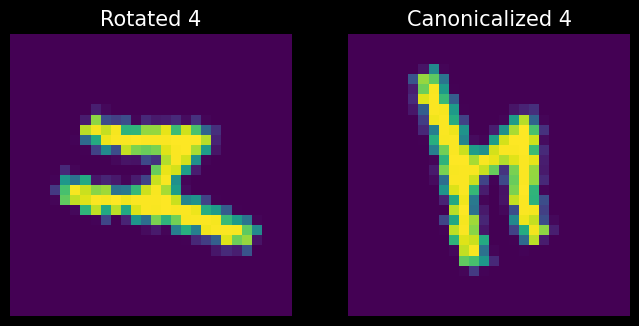

In [18]:
test_x, test_y = next(iter(rot_mnist_train_loader))
idx = 20
plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_x[idx, 0])
plt.title("Rotated " + str(test_y[idx].numpy()), size = 15)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(canonicalizer(test_x.to(device)).cpu().detach()[idx, 0])
plt.axis("off")
plt.title("Canonicalized " + str(test_y[idx].numpy()), size = 15)
plt.show()

In [2]:
import torch
from kornia.geometry.transform import rotate

# Example tensor
x = torch.randn(1, 3, 224, 224)

# Perform rotation
try:
    rotated_x = rotate(x, angle=torch.tensor(30.0), padding_mode='border')
except RuntimeError as e:
    print(f"Rotation failed: {e}")


In [3]:
rotated_x

tensor([[[[-0.7827, -0.5687, -0.8385,  ...,  0.3480,  0.4415, -0.0859],
          [ 0.0068, -1.2060, -0.1022,  ...,  0.0555, -0.3788, -0.0477],
          [-0.3750, -0.5711, -0.7395,  ..., -0.1364,  0.1948,  0.5824],
          ...,
          [ 0.0328,  0.2932, -1.3124,  ...,  0.0595, -1.3622, -1.9780],
          [-0.8822, -2.4878, -0.8579,  ...,  0.2749, -0.0982, -2.3809],
          [-1.4000,  0.6232,  1.4105,  ...,  0.5881,  0.1172, -0.9894]],

         [[ 1.4551,  1.2957,  0.7791,  ...,  0.0412, -0.0299, -0.1304],
          [ 1.7843,  1.2543,  1.3260,  ..., -0.1034, -0.1128,  0.6276],
          [ 0.8486,  1.5433,  1.2846,  ...,  0.4292,  1.1696,  0.3171],
          ...,
          [-1.8598, -1.7633, -0.8729,  ..., -0.9310, -1.7841, -1.1086],
          [-1.1114, -0.2210,  0.1071,  ...,  0.0064, -1.6172, -1.8378],
          [ 0.0375,  0.2972, -0.1382,  ...,  0.5550, -0.6798, -1.7645]],

         [[-0.6020, -0.8262, -0.6856,  ...,  0.5051,  0.3056,  0.4946],
          [-0.7494, -0.5409, -